In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import colormaps as cmaps

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.gridspec import GridSpec

In [10]:
acc_seen_df = pd.read_csv("./agren_40_long/emb_class_acc.csv")
acc_unseen_df = pd.read_csv("./agren_40_long/unused_accs.csv")
liver_df = pd.read_csv("./agren_40_long/nc_emb_Tl.csv").set_index("label")

In [11]:
liver_high_score_columns = sorted(liver_df.columns[liver_df.max() > 0.01])

In [12]:
renaming = pd.read_csv("./agren_40_long/seen_renaming.csv")

renaming_dict = {
    origional : rename
    for origional, rename in zip(renaming['origional'], renaming['rename'])
}

In [13]:
classifiers = sorted(acc_seen_df.columns.difference(['label', 'classifier_n']))
temp = classifiers[3]
classifiers[3] = classifiers[2]
classifiers[2] = temp

In [14]:
seen_labels = sorted(acc_seen_df['label'].unique())

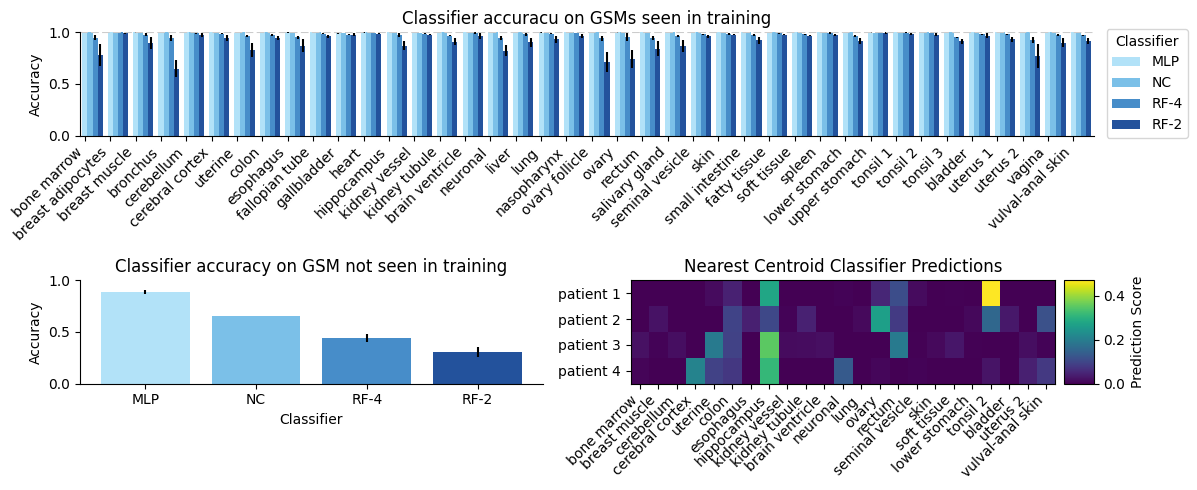

In [15]:
fig = plt.figure(figsize=(12, 5))

gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

classifier_colors = cmaps.WhiteBlue.discrete(7).colors[2:-1]

fontsize=10

# Top Acc Plot
x = np.arange(len(seen_labels))
width = 0.2

for i, c in enumerate(classifiers):
    offset = i * width

    accs = acc_seen_df.groupby('label')[c].mean()
    errs = acc_seen_df.groupby('label')[c].std().fillna(0)
    
    ax1.bar(x + offset, accs, yerr=errs, width=width, color=classifier_colors[i], label=c)

ax1.set_xticks(x, renaming['rename'], rotation=45, ha='right', fontsize=fontsize)
ax1.plot([-width, len(seen_labels) - width], [1, 1], color=[0.8, 0.8, 0.8], linestyle='--')
ax1.set_xlim([-width, len(seen_labels) - width])
ax1.set_ylim([0,1])
ax1.set_yticks([0, 0.5, 1])
ax1.spines[["top", 'right']].set_visible(False)
ax1.legend(bbox_to_anchor=(0.6, 0.6, 0.5, 0.5), title="Classifier")
ax1.set_ylabel("Accuracy")
ax1.set_title("Classifier accuracu on GSMs seen in training")

# Unseen accs
label_accs = acc_unseen_df.groupby('label').mean()
label_errss = acc_unseen_df.groupby('label').std().fillna(0)

ax2.bar(np.arange(4), label_accs.mean()[classifiers], yerr=label_errss.mean()[classifiers], color=classifier_colors)
ax2.set_xticks(np.arange(4), classifiers)
ax2.set_yticks([0, 0.5, 1])
ax2.spines[["top", "right"]].set_visible(False)
ax2.set_title("Classifier accuracy on GSM not seen in training")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Classifier")

# Heatmap
im = ax3.imshow(liver_df[liver_high_score_columns], aspect='auto', interpolation='nearest')

ax3_divider = make_axes_locatable(ax3)
cax = ax3_divider.append_axes("right", size="7%", pad="2%")

fig.colorbar(im, label="Prediction Score", aspect=5, anchor=(-0.2, 0.5), cax=cax)
ax3.set_yticks(range(4), [f"patient {i + 1}" for i in range(4)], fontsize=fontsize)

x_tick_labels = list(map(renaming_dict.__getitem__, liver_high_score_columns))
ax3.set_xticks(np.arange(len(liver_high_score_columns)), x_tick_labels, rotation=45, fontsize=fontsize, ha='right')

ax3.set_title("Nearest centroid classifier credictions")

fig.tight_layout()
fig.savefig("./images/F_emb_class.png", dpi=600)